# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes-v2/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'IQR', 'Var', 'Rmean_Var', 'Trans_Vol1',
       'Trans_Vol2', 'Rhythm', 'Subject'],
      dtype='object')


In [8]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_AppEn"]
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

    temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
    param_distributions = {'n_estimators': randint(105, 110),
                           'max_depth': randint(7,10)}

    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)

    n_estimators_list.append(search.best_params_['n_estimators'])
    max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=search.best_params_['max_depth'],n_estimators=search.best_params_['n_estimators'], random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

NameError: name 'model' is not defined

In [ ]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(n_estimators_list)
print(max_depth_list)
#old confusion matrix
#[23104  1639]
#  [ 1720 18505]]
# ---Run time is 155.16974349999873 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226

In [ ]:
# ---Run time is 199.88120800000615 seconds ---

# Accuracy of each fold: 
#  [0.9164759725400458, 0.9537525354969574, 0.9962216624685138, 0.9268585131894485, 0.9979101358411703, 0.959026369168357, 0.7678654834189631, 0.998638529611981, 0.9392570281124498, 0.9718853362734289, 0.9823049001814882, 0.990667623833453, 0.8285714285714286, 0.9560509554140127, 0.6040799333888426, 0.9880372175454143, 0.9897189856065799, 0.9873052510098096, 0.7514792899408284, 0.959868059373282, 0.9957228400342173, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9328978290249132

# Std of accuracy : 
# 0.09852275116924226
#[[23104  1639]
# [ 1720 18505]]

In [ ]:
temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.97:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(n_estimators_list[idx])
    print(max_depth_list[idx])

In [ ]:
import statistics

print(statistics.mode(n_estimators_list))
print(statistics.mode(max_depth_list))

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_AppEn"]
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=9,n_estimators=106, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [ ]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[22875  1868]
#  [ 1984 18241]]
# Accuracy of each fold: 
#  [0.9096109839816934, 0.9533468559837728, 0.9955919395465995, 0.8974820143884892, 0.9947753396029259, 0.9484787018255578, 0.832788416627744, 0.9965963240299524, 0.9362449799196787, 0.964167585446527, 0.9818511796733213, 0.9899497487437185, 0.7836734693877551, 0.9178343949044586, 0.4995836802664446, 0.9787328311918476, 0.9876627827278959, 0.9924985574148875, 0.7176669484361792, 0.9741616272677295, 0.9957228400342173, 0.9912115505335845, 0.9877378435517971]

# Avg accuracy : 
# 0.9229291563255121

# Std of accuracy : 
# 0.11533339006243011

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619765	valid_0's binary_logloss: 0.57164
[2]	training's binary_logloss: 0.560124	valid_0's binary_logloss: 0.522238
[3]	training's binary_logloss: 0.508587	valid_0's binary_logloss: 0.479894
[4]	training's binary_logloss: 0.464618	valid_0's binary_logloss: 0.445059
[5]	training's binary_logloss: 0.426647	valid_0's binary_logloss: 0.414774
[6]	training's binary_logloss: 0.393622	valid_0's binary_logloss: 0.388582
[7]	training's binary_logloss: 0.364582	valid_0's binary_logloss: 0.366626
[8]	training's binary_logloss: 0.338896	valid_0's binary_logloss: 0.347547
[9]	training's binary_logloss: 0.316233	valid_0's binary_logloss: 0.330751
[10]	training's binary_logloss: 0.29605	valid_0's binary_logloss: 0.316054
[11]	training's binary_logloss: 0.27816	valid_0's binary_logloss: 0.303448
[12]	training's binary_logloss: 0.262071	valid_0's binary_logloss: 0.293279
[13]	training's binary_logloss: 0.247708	valid_0's binary_logloss: 0.283832
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619408	valid_0's binary_logloss: 0.588822
[2]	training's binary_logloss: 0.56051	valid_0's binary_logloss: 0.533203
[3]	training's binary_logloss: 0.5095	valid_0's binary_logloss: 0.484294
[4]	training's binary_logloss: 0.465925	valid_0's binary_logloss: 0.442174
[5]	training's binary_logloss: 0.428186	valid_0's binary_logloss: 0.405512
[6]	training's binary_logloss: 0.395082	valid_0's binary_logloss: 0.373326
[7]	training's binary_logloss: 0.366318	valid_0's binary_logloss: 0.346072
[8]	training's binary_logloss: 0.340809	valid_0's binary_logloss: 0.321621
[9]	training's binary_logloss: 0.318304	valid_0's binary_logloss: 0.299597
[10]	training's binary_logloss: 0.298365	valid_0's binary_logloss: 0.280593
[11]	training's binary_logloss: 0.280589	valid_0's binary_logloss: 0.264163
[12]	training's binary_logloss: 0.264728	valid_0's binary_logloss: 0.248858
[13]	training's binary_logloss: 0.250411	valid_0's binary_logloss: 0.235995
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620378	valid_0's binary_logloss: 0.555556
[2]	training's binary_logloss: 0.561513	valid_0's binary_logloss: 0.493699
[3]	training's binary_logloss: 0.511578	valid_0's binary_logloss: 0.440559
[4]	training's binary_logloss: 0.468014	valid_0's binary_logloss: 0.394486
[5]	training's binary_logloss: 0.430459	valid_0's binary_logloss: 0.354373
[6]	training's binary_logloss: 0.397456	valid_0's binary_logloss: 0.319154
[7]	training's binary_logloss: 0.368681	valid_0's binary_logloss: 0.288338
[8]	training's binary_logloss: 0.343312	valid_0's binary_logloss: 0.261105
[9]	training's binary_logloss: 0.320919	valid_0's binary_logloss: 0.236854
[10]	training's binary_logloss: 0.301087	valid_0's binary_logloss: 0.215108
[11]	training's binary_logloss: 0.283361	valid_0's binary_logloss: 0.195765
[12]	training's binary_logloss: 0.267631	valid_0's binary_logloss: 0.178464
[13]	training's binary_logloss: 0.253252	valid_0's binary_logloss: 0.162886
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618538	valid_0's binary_logloss: 0.582749
[2]	training's binary_logloss: 0.558359	valid_0's binary_logloss: 0.541657
[3]	training's binary_logloss: 0.507223	valid_0's binary_logloss: 0.509669
[4]	training's binary_logloss: 0.463553	valid_0's binary_logloss: 0.48102
[5]	training's binary_logloss: 0.425606	valid_0's binary_logloss: 0.457341
[6]	training's binary_logloss: 0.392766	valid_0's binary_logloss: 0.436434
[7]	training's binary_logloss: 0.36379	valid_0's binary_logloss: 0.416206
[8]	training's binary_logloss: 0.338292	valid_0's binary_logloss: 0.396395
[9]	training's binary_logloss: 0.315724	valid_0's binary_logloss: 0.380359
[10]	training's binary_logloss: 0.295692	valid_0's binary_logloss: 0.367002
[11]	training's binary_logloss: 0.277927	valid_0's binary_logloss: 0.355263
[12]	training's binary_logloss: 0.262159	valid_0's binary_logloss: 0.345946
[13]	training's binary_logloss: 0.247969	valid_0's binary_logloss: 0.33651
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615913	valid_0's binary_logloss: 0.645331
[2]	training's binary_logloss: 0.557381	valid_0's binary_logloss: 0.571602
[3]	training's binary_logloss: 0.506872	valid_0's binary_logloss: 0.509301
[4]	training's binary_logloss: 0.463845	valid_0's binary_logloss: 0.456209
[5]	training's binary_logloss: 0.426661	valid_0's binary_logloss: 0.410263
[6]	training's binary_logloss: 0.394086	valid_0's binary_logloss: 0.37039
[7]	training's binary_logloss: 0.365741	valid_0's binary_logloss: 0.335261
[8]	training's binary_logloss: 0.34076	valid_0's binary_logloss: 0.304094
[9]	training's binary_logloss: 0.318667	valid_0's binary_logloss: 0.276629
[10]	training's binary_logloss: 0.299061	valid_0's binary_logloss: 0.252483
[11]	training's binary_logloss: 0.281384	valid_0's binary_logloss: 0.230885
[12]	training's binary_logloss: 0.26587	valid_0's binary_logloss: 0.2115
[13]	training's binary_logloss: 0.25199	valid_0's binary_logloss: 0.194311
[14]	training's binary_logl

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.620352	valid_0's binary_logloss: 0.590631
[2]	training's binary_logloss: 0.560112	valid_0's binary_logloss: 0.534147
[3]	training's binary_logloss: 0.509188	valid_0's binary_logloss: 0.485927
[4]	training's binary_logloss: 0.465488	valid_0's binary_logloss: 0.444859
[5]	training's binary_logloss: 0.427817	valid_0's binary_logloss: 0.409663
[6]	training's binary_logloss: 0.394841	valid_0's binary_logloss: 0.379276
[7]	training's binary_logloss: 0.366136	valid_0's binary_logloss: 0.352399
[8]	training's binary_logloss: 0.34074	valid_0's binary_logloss: 0.328856
[9]	training's binary_logloss: 0.318141	valid_0's binary_logloss: 0.308558
[10]	training's binary_logloss: 0.298295	valid_0's binary_logloss: 0.290257
[11]	training's binary_logloss: 0.280419	valid_0's binary_logloss: 0.278803
[12]	training's binary_logloss: 0.264499	valid_0's binary_logloss: 0.264104
[13]	training's binary_logloss: 0.250175	valid_0's binary_logloss: 0.255989
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	training's binary_logloss: 0.552359	valid_0's binary_logloss: 0.652994
[3]	training's binary_logloss: 0.501404	valid_0's binary_logloss: 0.613351
[4]	training's binary_logloss: 0.457597	valid_0's binary_logloss: 0.57872
[5]	training's binary_logloss: 0.419512	valid_0's binary_logloss: 0.547597
[6]	training's binary_logloss: 0.386111	valid_0's binary_logloss: 0.522847
[7]	training's binary_logloss: 0.356961	valid_0's binary_logloss: 0.501723
[8]	training's binary_logloss: 0.331269	valid_0's binary_logloss: 0.484355
[9]	training's binary_logloss: 0.308589	valid_0's binary_logloss: 0.470835
[10]	training's binary_logloss: 0.288388	valid_0's binary_logloss: 0.455546
[11]	training's binary_logloss: 0.270595	valid_0's binary_logloss: 0.443433
[12]	training's binary_logloss: 0.254789	valid_0's binary_logloss: 0.434816
[13]	training's binary_logloss: 0.240542	valid_0's binary_logloss: 0.425716
[14]	training's binary_logloss: 0.227769	valid_0's binary_logloss: 0.418809
[15]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	training's binary_logloss: 0.56125	valid_0's binary_logloss: 0.490197
[3]	training's binary_logloss: 0.511187	valid_0's binary_logloss: 0.437035
[4]	training's binary_logloss: 0.46761	valid_0's binary_logloss: 0.391043
[5]	training's binary_logloss: 0.430027	valid_0's binary_logloss: 0.350957
[6]	training's binary_logloss: 0.397229	valid_0's binary_logloss: 0.315768
[7]	training's binary_logloss: 0.3685	valid_0's binary_logloss: 0.284928
[8]	training's binary_logloss: 0.343156	valid_0's binary_logloss: 0.257526
[9]	training's binary_logloss: 0.320739	valid_0's binary_logloss: 0.233849
[10]	training's binary_logloss: 0.300856	valid_0's binary_logloss: 0.212126
[11]	training's binary_logloss: 0.283088	valid_0's binary_logloss: 0.19273
[12]	training's binary_logloss: 0.267288	valid_0's binary_logloss: 0.175291
[13]	training's binary_logloss: 0.253135	valid_0's binary_logloss: 0.159731
[14]	training's binary_logloss: 0.24055	valid_0's binary_logloss: 0.145724
[15]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614707	valid_0's binary_logloss: 0.666413
[2]	training's binary_logloss: 0.555549	valid_0's binary_logloss: 0.602753
[3]	training's binary_logloss: 0.505594	valid_0's binary_logloss: 0.548747
[4]	training's binary_logloss: 0.462042	valid_0's binary_logloss: 0.502885
[5]	training's binary_logloss: 0.424478	valid_0's binary_logloss: 0.463773
[6]	training's binary_logloss: 0.391677	valid_0's binary_logloss: 0.429965
[7]	training's binary_logloss: 0.362931	valid_0's binary_logloss: 0.400505
[8]	training's binary_logloss: 0.337539	valid_0's binary_logloss: 0.374879
[9]	training's binary_logloss: 0.315246	valid_0's binary_logloss: 0.351955
[10]	training's binary_logloss: 0.295179	valid_0's binary_logloss: 0.331451
[11]	training's binary_logloss: 0.27763	valid_0's binary_logloss: 0.314057
[12]	training's binary_logloss: 0.261885	valid_0's binary_logloss: 0.298991
[13]	training's binary_logloss: 0.247723	valid_0's binary_logloss: 0.285141
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	training's binary_logloss: 0.559954	valid_0's binary_logloss: 0.512245
[3]	training's binary_logloss: 0.509158	valid_0's binary_logloss: 0.46442
[4]	training's binary_logloss: 0.465685	valid_0's binary_logloss: 0.424767
[5]	training's binary_logloss: 0.428269	valid_0's binary_logloss: 0.390468
[6]	training's binary_logloss: 0.395549	valid_0's binary_logloss: 0.359755
[7]	training's binary_logloss: 0.366862	valid_0's binary_logloss: 0.332095
[8]	training's binary_logloss: 0.341656	valid_0's binary_logloss: 0.30804
[9]	training's binary_logloss: 0.319098	valid_0's binary_logloss: 0.286403
[10]	training's binary_logloss: 0.299424	valid_0's binary_logloss: 0.267385
[11]	training's binary_logloss: 0.281655	valid_0's binary_logloss: 0.249933
[12]	training's binary_logloss: 0.265748	valid_0's binary_logloss: 0.234944
[13]	training's binary_logloss: 0.251705	valid_0's binary_logloss: 0.221152
[14]	training's binary_logloss: 0.238846	valid_0's binary_logloss: 0.209237
[15]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.611111	valid_0's binary_logloss: 0.741672
[2]	training's binary_logloss: 0.552772	valid_0's binary_logloss: 0.655198
[3]	training's binary_logloss: 0.502772	valid_0's binary_logloss: 0.583527
[4]	training's binary_logloss: 0.460065	valid_0's binary_logloss: 0.522949
[5]	training's binary_logloss: 0.422803	valid_0's binary_logloss: 0.471073
[6]	training's binary_logloss: 0.390646	valid_0's binary_logloss: 0.426696
[7]	training's binary_logloss: 0.362478	valid_0's binary_logloss: 0.388024
[8]	training's binary_logloss: 0.337547	valid_0's binary_logloss: 0.354369
[9]	training's binary_logloss: 0.315638	valid_0's binary_logloss: 0.324406
[10]	training's binary_logloss: 0.296227	valid_0's binary_logloss: 0.298315
[11]	training's binary_logloss: 0.278806	valid_0's binary_logloss: 0.275083
[12]	training's binary_logloss: 0.263499	valid_0's binary_logloss: 0.254459
[13]	training's binary_logloss: 0.249605	valid_0's binary_logloss: 0.235744
[14]	training's binar

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619947	valid_0's binary_logloss: 0.554028
[2]	training's binary_logloss: 0.560944	valid_0's binary_logloss: 0.494253
[3]	training's binary_logloss: 0.510246	valid_0's binary_logloss: 0.442817
[4]	training's binary_logloss: 0.466562	valid_0's binary_logloss: 0.398687
[5]	training's binary_logloss: 0.429003	valid_0's binary_logloss: 0.360074
[6]	training's binary_logloss: 0.396446	valid_0's binary_logloss: 0.326506
[7]	training's binary_logloss: 0.367567	valid_0's binary_logloss: 0.296704
[8]	training's binary_logloss: 0.342177	valid_0's binary_logloss: 0.270453
[9]	training's binary_logloss: 0.319789	valid_0's binary_logloss: 0.247307
[10]	training's binary_logloss: 0.29992	valid_0's binary_logloss: 0.226788
[11]	training's binary_logloss: 0.282111	valid_0's binary_logloss: 0.208344
[12]	training's binary_logloss: 0.266331	valid_0's binary_logloss: 0.191854
[13]	training's binary_logloss: 0.25205	valid_0's binary_logloss: 0.177067
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615593	valid_0's binary_logloss: 0.654765
[2]	training's binary_logloss: 0.554623	valid_0's binary_logloss: 0.618663
[3]	training's binary_logloss: 0.502877	valid_0's binary_logloss: 0.589614
[4]	training's binary_logloss: 0.459277	valid_0's binary_logloss: 0.562006
[5]	training's binary_logloss: 0.420948	valid_0's binary_logloss: 0.540841
[6]	training's binary_logloss: 0.387322	valid_0's binary_logloss: 0.525599
[7]	training's binary_logloss: 0.358174	valid_0's binary_logloss: 0.514012
[8]	training's binary_logloss: 0.33241	valid_0's binary_logloss: 0.502924
[9]	training's binary_logloss: 0.309743	valid_0's binary_logloss: 0.488238
[10]	training's binary_logloss: 0.289415	valid_0's binary_logloss: 0.480921
[11]	training's binary_logloss: 0.271357	valid_0's binary_logloss: 0.472584
[12]	training's binary_logloss: 0.255268	valid_0's binary_logloss: 0.464885
[13]	training's binary_logloss: 0.24085	valid_0's binary_logloss: 0.461091
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613162	valid_0's binary_logloss: 0.751539
[2]	training's binary_logloss: 0.554784	valid_0's binary_logloss: 0.670789
[3]	training's binary_logloss: 0.504656	valid_0's binary_logloss: 0.610533
[4]	training's binary_logloss: 0.461737	valid_0's binary_logloss: 0.552302
[5]	training's binary_logloss: 0.424505	valid_0's binary_logloss: 0.504068
[6]	training's binary_logloss: 0.392195	valid_0's binary_logloss: 0.462191
[7]	training's binary_logloss: 0.363882	valid_0's binary_logloss: 0.427935
[8]	training's binary_logloss: 0.33895	valid_0's binary_logloss: 0.401301
[9]	training's binary_logloss: 0.316612	valid_0's binary_logloss: 0.378417
[10]	training's binary_logloss: 0.297051	valid_0's binary_logloss: 0.356491
[11]	training's binary_logloss: 0.279636	valid_0's binary_logloss: 0.334491
[12]	training's binary_logloss: 0.264087	valid_0's binary_logloss: 0.312728
[13]	training's binary_logloss: 0.250055	valid_0's binary_logloss: 0.291778
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.605868	valid_0's binary_logloss: 0.855796
[2]	training's binary_logloss: 0.54442	valid_0's binary_logloss: 0.843511
[3]	training's binary_logloss: 0.492371	valid_0's binary_logloss: 0.831996
[4]	training's binary_logloss: 0.447983	valid_0's binary_logloss: 0.827284
[5]	training's binary_logloss: 0.409707	valid_0's binary_logloss: 0.823618
[6]	training's binary_logloss: 0.376395	valid_0's binary_logloss: 0.82458
[7]	training's binary_logloss: 0.347347	valid_0's binary_logloss: 0.825567
[8]	training's binary_logloss: 0.32152	valid_0's binary_logloss: 0.829777
[9]	training's binary_logloss: 0.298774	valid_0's binary_logloss: 0.833578
[10]	training's binary_logloss: 0.278777	valid_0's binary_logloss: 0.833899
[11]	training's binary_logloss: 0.260587	valid_0's binary_logloss: 0.839881
[12]	training's binary_logloss: 0.244748	valid_0's binary_logloss: 0.848124
[13]	training's binary_logloss: 0.230653	valid_0's binary_logloss: 0.848416
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.614575	valid_0's binary_logloss: 0.671003
[2]	training's binary_logloss: 0.555206	valid_0's binary_logloss: 0.601397
[3]	training's binary_logloss: 0.505062	valid_0's binary_logloss: 0.544452
[4]	training's binary_logloss: 0.462025	valid_0's binary_logloss: 0.494777
[5]	training's binary_logloss: 0.424958	valid_0's binary_logloss: 0.45123
[6]	training's binary_logloss: 0.392595	valid_0's binary_logloss: 0.41256
[7]	training's binary_logloss: 0.364236	valid_0's binary_logloss: 0.379518
[8]	training's binary_logloss: 0.339297	valid_0's binary_logloss: 0.350833
[9]	training's binary_logloss: 0.317245	valid_0's binary_logloss: 0.324877
[10]	training's binary_logloss: 0.297454	valid_0's binary_logloss: 0.301846
[11]	training's binary_logloss: 0.279848	valid_0's binary_logloss: 0.280619
[12]	training's binary_logloss: 0.264132	valid_0's binary_logloss: 0.261003
[13]	training's binary_logloss: 0.250099	valid_0's binary_logloss: 0.244129
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619135	valid_0's binary_logloss: 0.56997
[2]	training's binary_logloss: 0.560188	valid_0's binary_logloss: 0.508075
[3]	training's binary_logloss: 0.509529	valid_0's binary_logloss: 0.454749
[4]	training's binary_logloss: 0.46596	valid_0's binary_logloss: 0.408864
[5]	training's binary_logloss: 0.428383	valid_0's binary_logloss: 0.368758
[6]	training's binary_logloss: 0.39565	valid_0's binary_logloss: 0.334015
[7]	training's binary_logloss: 0.367035	valid_0's binary_logloss: 0.303382
[8]	training's binary_logloss: 0.341818	valid_0's binary_logloss: 0.276219
[9]	training's binary_logloss: 0.319545	valid_0's binary_logloss: 0.252455
[10]	training's binary_logloss: 0.299778	valid_0's binary_logloss: 0.231163
[11]	training's binary_logloss: 0.28196	valid_0's binary_logloss: 0.212171
[12]	training's binary_logloss: 0.26633	valid_0's binary_logloss: 0.195083
[13]	training's binary_logloss: 0.252236	valid_0's binary_logloss: 0.179977
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.615144	valid_0's binary_logloss: 0.673907
[2]	training's binary_logloss: 0.556844	valid_0's binary_logloss: 0.596927
[3]	training's binary_logloss: 0.506414	valid_0's binary_logloss: 0.531927
[4]	training's binary_logloss: 0.463403	valid_0's binary_logloss: 0.479505
[5]	training's binary_logloss: 0.425887	valid_0's binary_logloss: 0.431532
[6]	training's binary_logloss: 0.393373	valid_0's binary_logloss: 0.389138
[7]	training's binary_logloss: 0.364981	valid_0's binary_logloss: 0.353083
[8]	training's binary_logloss: 0.340098	valid_0's binary_logloss: 0.323869
[9]	training's binary_logloss: 0.31794	valid_0's binary_logloss: 0.295072
[10]	training's binary_logloss: 0.298258	valid_0's binary_logloss: 0.269531
[11]	training's binary_logloss: 0.280634	valid_0's binary_logloss: 0.246676
[12]	training's binary_logloss: 0.264872	valid_0's binary_logloss: 0.228518
[13]	training's binary_logloss: 0.250992	valid_0's binary_logloss: 0.212308
[14]	training's binary

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.616697	valid_0's binary_logloss: 0.633429
[2]	training's binary_logloss: 0.555207	valid_0's binary_logloss: 0.617607
[3]	training's binary_logloss: 0.503231	valid_0's binary_logloss: 0.59904
[4]	training's binary_logloss: 0.458227	valid_0's binary_logloss: 0.582392
[5]	training's binary_logloss: 0.419439	valid_0's binary_logloss: 0.56918
[6]	training's binary_logloss: 0.385333	valid_0's binary_logloss: 0.563222
[7]	training's binary_logloss: 0.355397	valid_0's binary_logloss: 0.553442
[8]	training's binary_logloss: 0.329086	valid_0's binary_logloss: 0.550427
[9]	training's binary_logloss: 0.305698	valid_0's binary_logloss: 0.547807
[10]	training's binary_logloss: 0.285245	valid_0's binary_logloss: 0.5449
[11]	training's binary_logloss: 0.266895	valid_0's binary_logloss: 0.542049
[12]	training's binary_logloss: 0.250437	valid_0's binary_logloss: 0.541792
[13]	training's binary_logloss: 0.23572	valid_0's binary_logloss: 0.542154
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.618973	valid_0's binary_logloss: 0.588366
[2]	training's binary_logloss: 0.55999	valid_0's binary_logloss: 0.531719
[3]	training's binary_logloss: 0.509062	valid_0's binary_logloss: 0.482182
[4]	training's binary_logloss: 0.465697	valid_0's binary_logloss: 0.439051
[5]	training's binary_logloss: 0.428178	valid_0's binary_logloss: 0.402064
[6]	training's binary_logloss: 0.395429	valid_0's binary_logloss: 0.368957
[7]	training's binary_logloss: 0.366928	valid_0's binary_logloss: 0.340852
[8]	training's binary_logloss: 0.341667	valid_0's binary_logloss: 0.315894
[9]	training's binary_logloss: 0.319244	valid_0's binary_logloss: 0.293435
[10]	training's binary_logloss: 0.29936	valid_0's binary_logloss: 0.273481
[11]	training's binary_logloss: 0.281704	valid_0's binary_logloss: 0.255811
[12]	training's binary_logloss: 0.265849	valid_0's binary_logloss: 0.238737
[13]	training's binary_logloss: 0.251733	valid_0's binary_logloss: 0.225271
[14]	training's binary_

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.613887	valid_0's binary_logloss: 0.682083
[2]	training's binary_logloss: 0.55556	valid_0's binary_logloss: 0.60709
[3]	training's binary_logloss: 0.505267	valid_0's binary_logloss: 0.543081
[4]	training's binary_logloss: 0.462436	valid_0's binary_logloss: 0.487552
[5]	training's binary_logloss: 0.425452	valid_0's binary_logloss: 0.440186
[6]	training's binary_logloss: 0.393066	valid_0's binary_logloss: 0.398447
[7]	training's binary_logloss: 0.364905	valid_0's binary_logloss: 0.362994
[8]	training's binary_logloss: 0.340095	valid_0's binary_logloss: 0.331343
[9]	training's binary_logloss: 0.318065	valid_0's binary_logloss: 0.303718
[10]	training's binary_logloss: 0.29856	valid_0's binary_logloss: 0.27944
[11]	training's binary_logloss: 0.281151	valid_0's binary_logloss: 0.257364
[12]	training's binary_logloss: 0.265686	valid_0's binary_logloss: 0.238098
[13]	training's binary_logloss: 0.25176	valid_0's binary_logloss: 0.220685
[14]	training's binary_log

C:\Users\NNL\anacondareal\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	training's binary_logloss: 0.619204	valid_0's binary_logloss: 0.559803
[2]	training's binary_logloss: 0.559788	valid_0's binary_logloss: 0.498886
[3]	training's binary_logloss: 0.509456	valid_0's binary_logloss: 0.447159
[4]	training's binary_logloss: 0.466317	valid_0's binary_logloss: 0.401842
[5]	training's binary_logloss: 0.42894	valid_0's binary_logloss: 0.362866
[6]	training's binary_logloss: 0.396336	valid_0's binary_logloss: 0.327723
[7]	training's binary_logloss: 0.367852	valid_0's binary_logloss: 0.297233
[8]	training's binary_logloss: 0.342656	valid_0's binary_logloss: 0.270948
[9]	training's binary_logloss: 0.320361	valid_0's binary_logloss: 0.246795
[10]	training's binary_logloss: 0.300497	valid_0's binary_logloss: 0.22512
[11]	training's binary_logloss: 0.282929	valid_0's binary_logloss: 0.20591
[12]	training's binary_logloss: 0.267153	valid_0's binary_logloss: 0.188505
[13]	training's binary_logloss: 0.253062	valid_0's binary_logloss: 0.173036
[14]	training's binary_l

C:\Users\NNL\anacondareal\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	training's binary_logloss: 0.555733	valid_0's binary_logloss: 0.600451
[3]	training's binary_logloss: 0.505313	valid_0's binary_logloss: 0.536793
[4]	training's binary_logloss: 0.46236	valid_0's binary_logloss: 0.484026
[5]	training's binary_logloss: 0.425255	valid_0's binary_logloss: 0.438134
[6]	training's binary_logloss: 0.393067	valid_0's binary_logloss: 0.397988
[7]	training's binary_logloss: 0.364841	valid_0's binary_logloss: 0.36228
[8]	training's binary_logloss: 0.339995	valid_0's binary_logloss: 0.331299
[9]	training's binary_logloss: 0.317879	valid_0's binary_logloss: 0.303612
[10]	training's binary_logloss: 0.298375	valid_0's binary_logloss: 0.27959
[11]	training's binary_logloss: 0.281032	valid_0's binary_logloss: 0.258415
[12]	training's binary_logloss: 0.265584	valid_0's binary_logloss: 0.238706
[13]	training's binary_logloss: 0.251629	valid_0's binary_logloss: 0.221623
[14]	training's binary_logloss: 0.239227	valid_0's binary_logloss: 0.206285
[15]	training's binary_

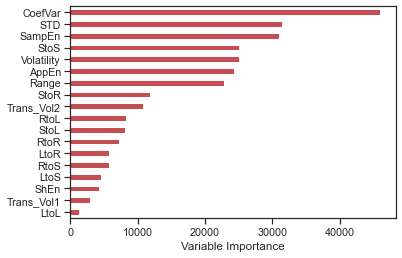

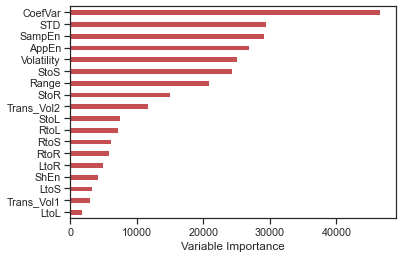

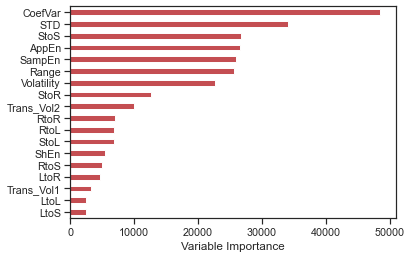

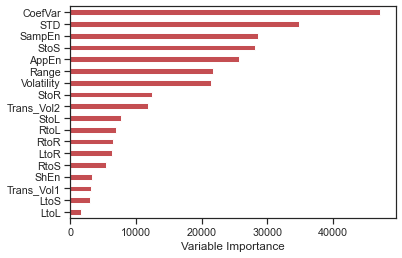

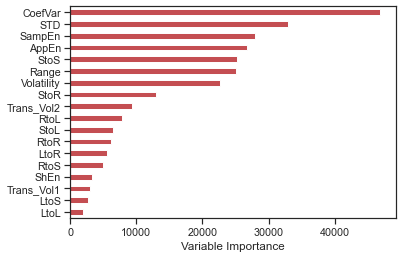

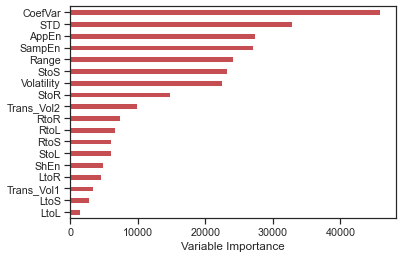

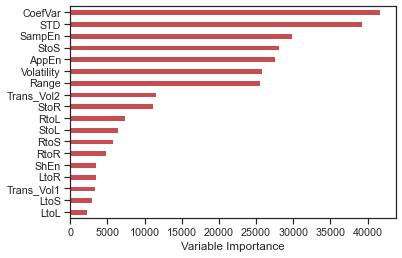

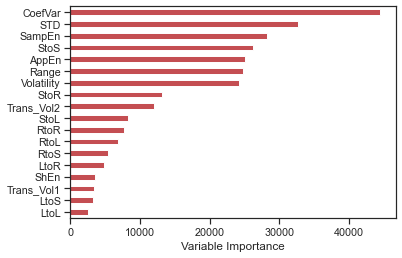

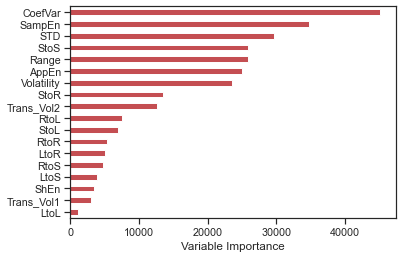

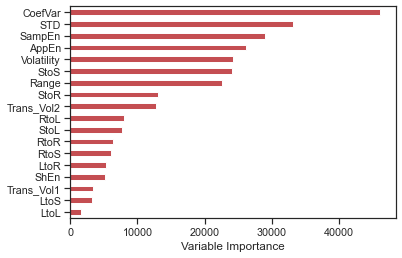

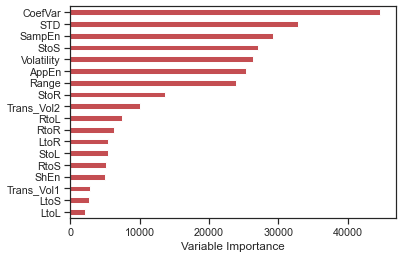

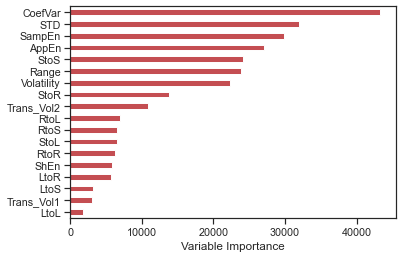

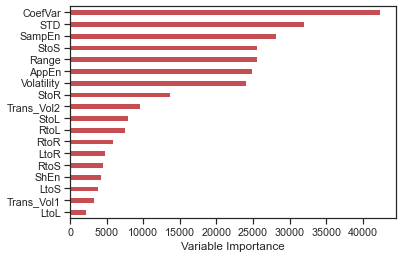

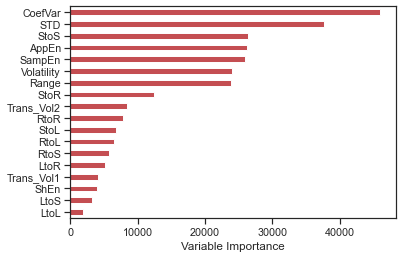

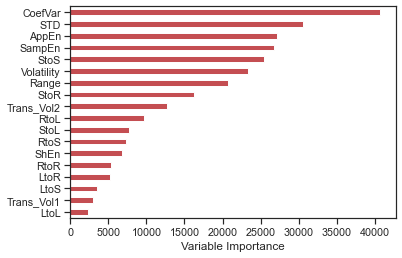

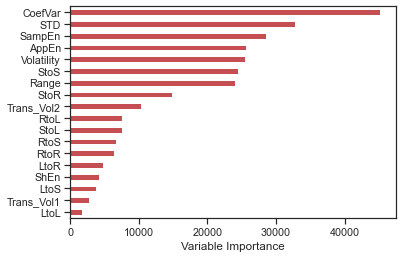

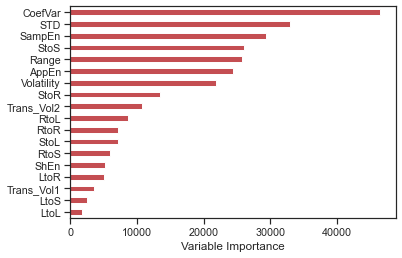

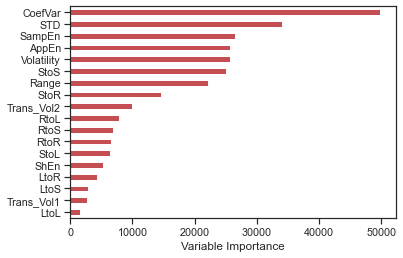

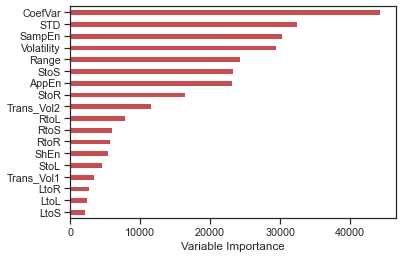

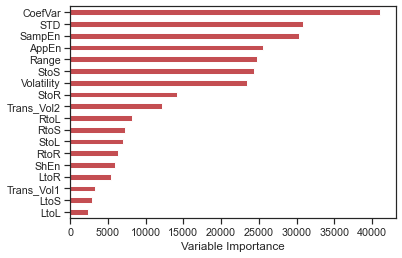

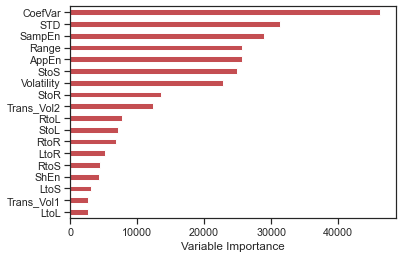

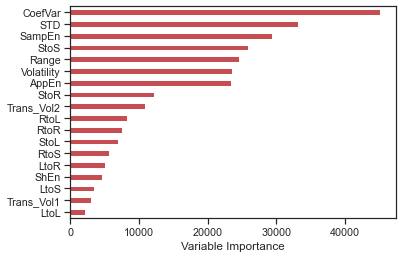

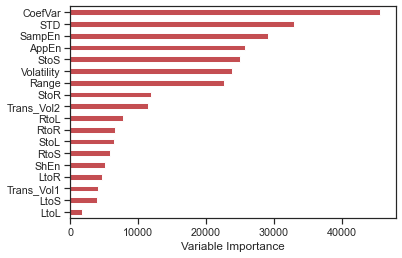

In [8]:
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)


from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn',"Trans_Vol1","Trans_Vol2"]
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
#     param_distributions = {'n_estimators': randint(105, 110),
#                            'max_depth': randint(7,10)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     n_estimators_list.append(search.best_params_['n_estimators'])
#     max_depth_list.append(search.best_params_['max_depth'])

#     model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
#           eval_metric='logloss')
    model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=5, random_state=42)
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [17]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

[[23040  1703]
 [ 1714 18511]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.92      0.92     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9124713958810069, 0.9557809330628804, 0.9962216624685138, 0.9280575539568345, 0.9973876698014629, 0.9513184584178499, 0.7888836992059786, 0.9979577944179714, 0.9382530120481928, 0.9713340683572216, 0.9841197822141561, 0.9913854989231874, 0.8108843537414966, 0.9579617834394905, 0.5799333888426311, 0.9893664155959238, 0.9924605894448252, 0.986728216964801, 0.7421808960270498, 0.9736118746564046, 0.9957228400342173, 0.9968612680477087, 0.99830866807611]
8.181374699997832
